In [20]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [21]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [22]:
urls = search_images_ddg('grizzly bear photos', max_images=1)
len(urls),urls[0]

(1,
 'http://3.bp.blogspot.com/-6VJBVEQKaFc/TgbRVFNtahI/AAAAAAAAAFY/BpIqDsfc9JY/s1600/102487-050-BD924456.jpg')

In [23]:
!pip install duckduckgo_search


Searching for 'grizzly bear photo'...
Downloaded grizzly bear images
Searching for 'polar bear photo'...
Error downloading https://www.expeditionsalaska.com/wp-content/uploads/2016/11/15-polar-bear-photo-4443.jpg: HTTP Error 502: Bad Gateway
====Error Body====
<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>


<title>www.expeditionsalaska.com | 502: Bad gateway</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />


</he
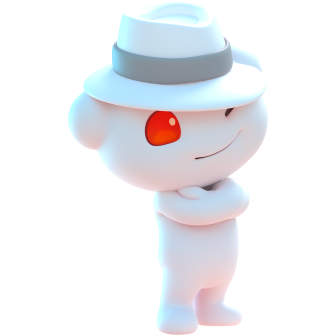

In [24]:
from duckduckgo_search import DDGS
from fastdownload import download_url
from fastai.vision.all import *
import time
from pathlib import Path

# Search function
def search_images(term, max_images=30):
    print(f"Searching for '{term}'...")
    with DDGS() as ddgs:
        return L(ddgs.images(term, max_results=max_images)).itemgot('image')

# Download function
def download_images(dest, urls, max_pics=30):
    dest.mkdir(exist_ok=True)
    for i, url in enumerate(urls[:max_pics]):
        if i >= max_pics: break
        fname = dest/f'{i:03d}.jpg'
        try:
            download_url(url, fname, show_progress=False)
            # print(f'Downloaded {url} to {fname}')
            time.sleep(0.1)
        except Exception as e:
            print(f'Error downloading {url}: {e}')
            if fname.exists(): fname.unlink()

# Main process
bear_types = ['grizzly', 'polar', 'gummy']
no_bear_searches = [
    "landscape nature photo",
    "factory employees photo",
    "car photo",
    "furniture photo",
    "food photo",
    "people portrait photo",
    "sports action photo",
    "building architecture photo"
]
path = Path('bears_multi')

# Create the main directory
path.mkdir(exist_ok=True, parents=True)

# Download bear images
for bear_type in bear_types:
    dest = (path/bear_type)
    dest.mkdir(exist_ok=True)
    urls = search_images(f'{bear_type} bear photo')
    download_images(dest, urls, max_pics=30)
    print(f"Downloaded {bear_type} bear images")

# Create and populate the no_bear directory
no_bear_dir = path/'no_bear'
no_bear_dir.mkdir(exist_ok=True)

# Download non-bear images
for search_term in no_bear_searches:
    urls = search_images(search_term)
    download_images(no_bear_dir, urls, max_pics=5)
    print(f"Downloaded images for '{search_term}'")

# Count the total number of images
fns = get_image_files(path)
print(f"Number of images downloaded: {len(fns)}")

In [25]:
# Check and remove invalid images
import os
from PIL import Image

valid_images = []
invalid_images = []

for img_path in get_image_files(path):
    try:
        # Try to open the image
        img = Image.open(img_path)
        # Verify it can be read
        img.verify()
        valid_images.append(img_path)
    except Exception as e:
        print(f"Invalid image {img_path}: {e}")
        invalid_images.append(img_path)
        # Delete the invalid file
        os.remove(img_path)

print(f"Valid images: {len(valid_images)}")
print(f"Invalid images removed: {len(invalid_images)}")

Invalid image bears_multi/gummy/022.jpg: cannot identify image file 'bears_multi/gummy/022.jpg'
Invalid image bears_multi/grizzly/011.jpg: cannot identify image file 'bears_multi/grizzly/011.jpg'
Invalid image bears_multi/polar/017.jpg: cannot identify image file 'bears_multi/polar/017.jpg'
Valid images: 213
Invalid images removed: 3


In [26]:
# Check if we have images
fns = get_image_files(path)
print(f"Number of images: {len(fns)}")

# Check the first few image paths to ensure they're in the right structure
for i, fn in enumerate(fns[:5]):
    print(fn)
    if i >= 4: break

Number of images: 213
bears_multi/teddy/008.jpg
bears_multi/teddy/015.jpg
bears_multi/teddy/003.jpg
bears_multi/teddy/004.jpg
bears_multi/teddy/022.jpg


In [27]:
# Create the CSV file with multi-label annotations
import pandas as pd

# Initialize an empty dataframe
data = []

# Go through all images
for img_path in get_image_files(path):
    # Get the folder name (original label)
    folder = img_path.parent.name

    # Create a row with binary values for each class
    row = {'path': str(img_path.relative_to(path))}
    for bear_type in bear_types + no_bear_searches:
        row[bear_type] = 1 if bear_type == folder else 0

    data.append(row)

# Create DataFrame and save to CSV
df = pd.DataFrame(data)
df.to_csv(path/'labels.csv', index=False)
print(f"Created CSV with {len(df)} images")

# Look at the first few rows to verify
print(df.head())

Created CSV with 213 images
            path  grizzly  polar  gummy  landscape nature photo  \
0  teddy/008.jpg        0      0      0                       0   
1  teddy/015.jpg        0      0      0                       0   
2  teddy/003.jpg        0      0      0                       0   
3  teddy/004.jpg        0      0      0                       0   
4  teddy/022.jpg        0      0      0                       0   

   factory employees photo  car photo  furniture photo  food photo  \
0                        0          0                0           0   
1                        0          0                0           0   
2                        0          0                0           0   
3                        0          0                0           0   
4                        0          0                0           0   

   people portrait photo  sports action photo  building architecture photo  
0                      0                    0                          

In [28]:
# Load the CSV first
labels_df = pd.read_csv(path/'labels.csv')

def get_multi_labels(fname):
    # Get relative path to match CSV
    img_path = str(fname.relative_to(path))

    # Find the image in our dataframe
    try:
        row = labels_df.loc[labels_df['path'] == img_path].iloc[0]
        # Return list of categories with value 1
        return [c for c in bear_types + no_bear_searches if row[c] == 1]
    except (IndexError, KeyError):
        print(f"Warning: Could not find {img_path} in CSV")
        return []  # Return empty list if not found

# Recreate the DataBlock with debugging
bears_multi = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,  # Label from parent folder
    item_tfms=Resize(224),  # This is crucial - it resizes each image to 224×224
    batch_tfms=[
        *aug_transforms(mult=2, size=224),  # More aggressive augmentation
        Normalize.from_stats(*imagenet_stats)
    ]
)

# Create DataLoaders with verbose=True to see more info
dls = bears_multi.dataloaders(path, verbose=True)

Found 213 items
2 datasets of sizes 171,42
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resize -- {'size': (224, 224), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.4, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}


In [29]:
# Show some of our training images with their labels
# Try recreating the DataLoaders with a smaller batch size
dls = bears_multi.dataloaders(path, bs=4, verbose=True)

# Check our category vocabulary
print("Categories:", dls.vocab)

Found 213 items
2 datasets of sizes 171,42
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resize -- {'size': (224, 224), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.4, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Categories: ['car photo', 'city skyline photo', 'furniture photo', 'grizzly', '

In [30]:
# For multi-class (not multi-label) classification
learn = vision_learner(dls, resnet34, metrics=error_rate)  # Using standard error_rate metric

# Training with more careful fine-tuning
learn.fine_tune(3, base_lr=1e-3, freeze_epochs=3)  # Train for more epochs

epoch,train_loss,valid_loss,error_rate,time
0,3.369026,2.220655,0.785714,00:27
1,2.448114,0.825270,0.238095,00:15
2,1.874511,0.612724,0.166667,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.090003,0.463453,0.166667,00:13
1,1.043751,0.419697,0.166667,00:13
2,0.857147,0.488040,0.095238,00:13


In [36]:
# Create upload button
from fastai.vision.widgets import FileUpload, Output
from IPython.display import display, clear_output

# Create widgets
upload_btn = FileUpload()
output_widget = Output()

# Display the widgets
display(upload_btn)
display(output_widget)


FileUpload(value={}, description='Upload')

Output()

In [ ]:
def predict_multi(img_file):
    # Process the uploaded file
    img = PILImage.create(img_file)

    # Get prediction
    pred, pred_idx, probs = learn.predict(img)

    # Prepare output
    with output_widget:
        clear_output()
        display(img.to_thumb(256, 256))

        # Show all class probabilities
        print("Prediction probabilities:")
        for c, p in zip(dls.vocab, probs):
            print(f"{c}: {p:.4f}")

        # Show classes exceeding threshold
        print("\nClasses detected (threshold=0.5):")
        detected = [c for c, p in zip(dls.vocab, probs) if p > 0.5]
        if detected:
            print(", ".join(detected))
        else:
            print("No classes detected above threshold")

# Link the upload button to the prediction function
def on_upload_change(change):
    if change['type'] == 'change' and change['name'] == 'value' and len(upload_btn.data) > 0:
        # Get the file
        img_file = upload_btn.data[-1]
        predict_multi(img_file)

# Register the callback
upload_btn.observe(on_upload_change, names=['data'])

# Only if automatic prediction isn't working
if len(upload_btn.data) > 0:
    img_file = upload_btn.data[-1]
    predict_multi(img_file)

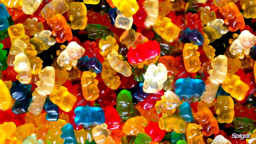

In [ ]:
from fastdownload import download_url
dest = 'bear.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [ ]:
from fastai.vision.all import *
import os
from PIL import Image
import pathlib

# Define all possible categories
categories = ['grizzly', 'blue', 'gummy']

# Create a function that returns a list of applicable labels
def get_y_multi(img_path):
    # Get parent folder name
    category = img_path.parent.name

    # For known bear types, return just that category
    if category in categories:
        return [category]
    # For non-bears, return an empty list
    else:
        return []

# First, let's clean up corrupted images
path = pathlib.Path('bears')

# Function to get only valid images
def get_valid_images(path):
    files = get_image_files(path)
    valid_files = []
    for f in files:
        try:
            # Try to open each image
            img = PILImage.create(f)
            valid_files.append(f)
        except Exception as e:
            print(f"Skipping invalid image: {f}")
    return valid_files

# Create the DataBlock properly
bears_multi = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(vocab=categories)),
    get_items=lambda p: get_valid_images(p),  # Use our custom function to get valid images
    get_y=get_y_multi,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(size=128)
)

# Create DataLoaders
dls = bears_multi.dataloaders(path)

# Create learner with binary cross-entropy loss
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.5))

# Train the model
learn.fit_one_cycle(4)

def predict_with_thresholds(img, learn, thresh=0.5):
    # Get prediction probabilities
    _, _, probs = learn.predict(img)

    # Convert to list of predicted categories
    pred_categories = []
    for i, prob in enumerate(probs):
        if prob > thresh:
            pred_categories.append(learn.dls.vocab[i])

    # If no categories meet threshold, it's a non-bear
    if len(pred_categories) == 0:
        return "non-bear"
    else:
        return ", ".join(pred_categories)

Skipping invalid image: bears/blue/000.jpg


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 53.1MB/s]


epoch,train_loss,valid_loss,accuracy_multi,time
0,nan,2.159140,0.266667,00:05
1,nan,2.159140,0.266667,00:03
2,nan,2.159140,0.266667,00:05
3,nan,2.159140,0.266667,00:04


/usr/local/lib/python3.11/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
# First, verify your images actually downloaded
from pathlib import Path
path = Path('bears')

# Check how many images are in each directory
for bear_type in ['grizzly', 'blue', 'gummy']:
    bear_path = path/bear_type
    if bear_path.exists():
        files = list(bear_path.glob('*.jpg'))
        print(f"{bear_type}: {len(files)} images")
    else:
        print(f"{bear_type} directory doesn't exist")

grizzly: 10 images
blue: 9 images
gummy: 10 images


Our folder has image files, as we'd expect:

In [ ]:
fns = get_image_files(path)
fns

(#29) [Path('bears/blue/002.jpg'),Path('bears/blue/006.jpg'),Path('bears/blue/008.jpg'),Path('bears/blue/005.jpg'),Path('bears/blue/003.jpg'),Path('bears/blue/009.jpg'),Path('bears/blue/007.jpg'),Path('bears/blue/001.jpg'),Path('bears/blue/000.jpg'),Path('bears/grizzly/002.jpg'),Path('bears/grizzly/006.jpg'),Path('bears/grizzly/008.jpg'),Path('bears/grizzly/004.jpg'),Path('bears/grizzly/005.jpg'),Path('bears/grizzly/003.jpg'),Path('bears/grizzly/009.jpg'),Path('bears/grizzly/007.jpg'),Path('bears/grizzly/001.jpg'),Path('bears/grizzly/000.jpg'),Path('bears/gummy/002.jpg')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [ ]:
failed = verify_images(fns)
failed

(#1) [Path('bears/blue/000.jpg')]

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [ ]:
# Add missing_ok=True to handle files that might already be gone
for f in failed:
    try:
        f.unlink(missing_ok=True)  # This will not raise an error if file is already gone
    except Exception as e:
        print(f"Could not remove {f}: {e}")

# Now let's check what we have left
fns = get_image_files(path)
print(f"\nRemaining valid images: {len(fns)}")


Remaining valid images: 28


In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(size=128)
    )

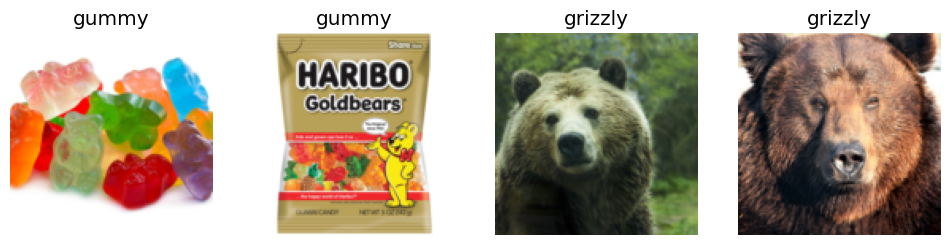

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

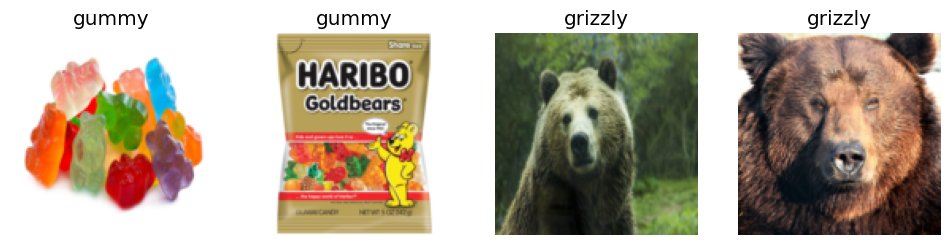

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

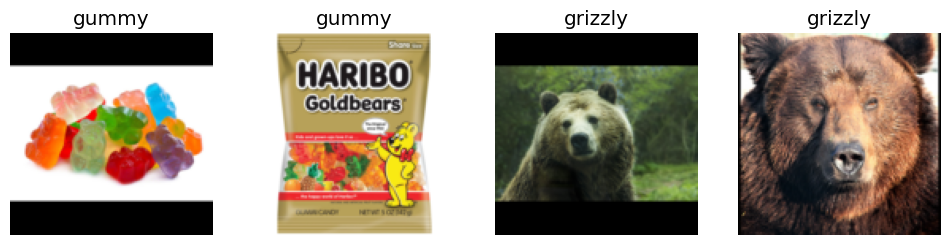

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

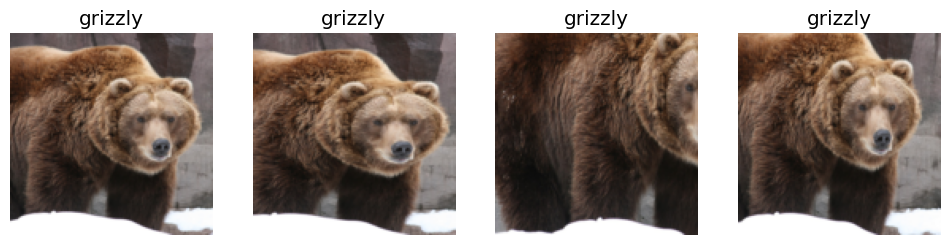

In [ ]:
# Simplified DataBlock
bears_simple = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=RandomResizedCrop(128,  min_scale=0.3))

# Create dataloaders with minimal batch size
dls_simple = bears_simple.dataloaders(path, bs=4)

dls_simple.train.show_batch(max_n=4,nrows=1,unique=True)

We used `unique=True` to have the same image repeated with different versions of this `RandomResizedCrop` transform. This is a specific example of a more general technique, called data augmentation.

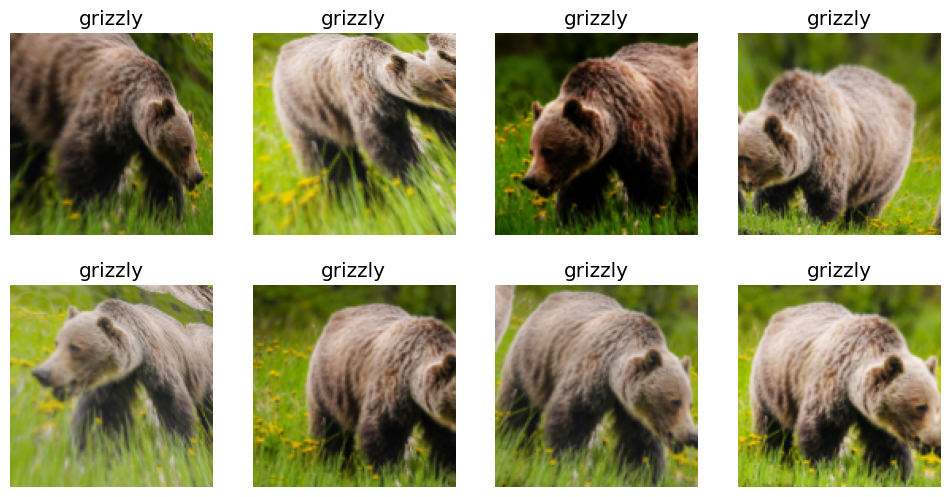

In [ ]:
bears_augment = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))

dls = bears_augment.dataloaders(path, bs=16)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path, bs=29)

We can now create our `Learner` and fine-tune it in the usual way:

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 97.4MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,nan,3.052077,0.800000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,nan,3.052077,0.800000,00:02
1,nan,3.052077,0.800000,00:02
2,nan,3.052077,0.800000,00:02
3,nan,3.052077,0.800000,00:02


Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a *confusion matrix*:

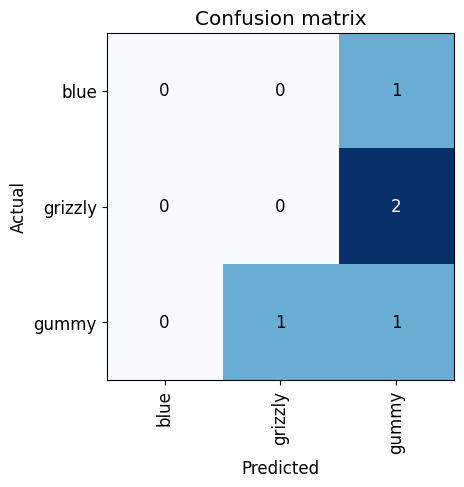

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

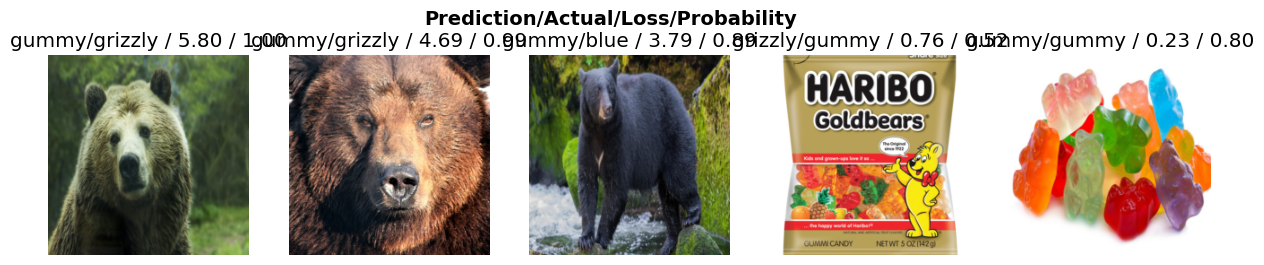

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(size=128)
)

# Create dataloaders
dls = bears.dataloaders(path)

# Then set the vocabulary explicitly
dls.vocab = ['grizzly', 'blue', 'gummy']  # Set in the order you want

# Now train with these dataloaders
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)
learn.export('bears_fixed.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,nan,5.366029,0.600000,00:02


/usr/local/lib/python3.11/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,error_rate,time
0,nan,5.366029,0.600000,00:02
1,nan,5.366029,0.600000,00:05
2,nan,5.366029,0.600000,00:03


removed


In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('bears_fixed.pkl')]

In [ ]:
learn.export('bears.pkl')
!ls *.pkl



bears_fixed.pkl  bears.pkl


In [ ]:
learn_inf = load_learner('bears.pkl')
print(learn_inf.dls.vocab)

['blue', 'grizzly', 'gummy']


In [ ]:
learn_inf.predict('bears/grizzly/003.jpg')

('grizzly', tensor(1), tensor([0.0012, 0.8299, 0.1690]))

In [ ]:
learn_inf.dls.vocab

['blue', 'grizzly', 'gummy']

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

<img alt="An upload button" width="159" src="https://github.com/fastai/fastbook/blob/master/images/att_00008.png?raw=1">

Now we can grab the image:

In [ ]:
img = PILImage.create(btn_upload.data[-1])

We can use an `Output` widget to display it:

In [ ]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: gummy; Probability: 0.9814')

In [ ]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
#hide_output
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post.